In [1]:
#Librerias 
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#Procesamiento de datos y ml
#Data processing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

#carga de modelos entrenados
#Load trained models
import joblib
#Modelo a usar de machine learning
#ML model to use
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
#Referencias
#References
#https://www.kaggle.com/code/alirezahasannejad/xgboost-classifier-tutorial
#https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data

In [3]:
#Carga de dataset
#Load dataset   
df=pd.read_csv("./dataset/healthcare-dataset.csv")
#Lectura de datos
#Read first 10 row
print(df.head(10))

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   
5  56669    Male  81.0             0              0          Yes   
6  53882    Male  74.0             1              1          Yes   
7  10434  Female  69.0             0              0           No   
8  27419  Female  59.0             0              0          Yes   
9  60491  Female  78.0             0              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private    

In [4]:
#Se elimina la columna id
#Delete the id column
df.drop('id', axis=1, inplace=True)
#Se eliminan filas con valores faltantes
#Delete rows with missing values
df.dropna(inplace=True)
#Se codifican variables categóricas con LabelEncoder
#Encode categorical variables with LabelEncoder
le=LabelEncoder()
df['gender']=le.fit_transform(df['gender'])
df['ever_married'] = le.fit_transform(df['ever_married'])
df['Residence_type'] = le.fit_transform(df['Residence_type']) 
#Codificación one-hot para otras variables
#One-hot encoding for other variables
df = pd.get_dummies(df, columns=['work_type', 'smoking_status'])
#muestra el resultado
#Show result
print(df.head())

   gender   age  hypertension  heart_disease  ever_married  Residence_type  \
0       1  67.0             0              1             1               1   
2       1  80.0             0              1             1               0   
3       0  49.0             0              0             1               1   
4       0  79.0             1              0             1               0   
5       1  81.0             0              0             1               1   

   avg_glucose_level   bmi  stroke  work_type_Govt_job  \
0             228.69  36.6       1               False   
2             105.92  32.5       1               False   
3             171.23  34.4       1               False   
4             174.12  24.0       1               False   
5             186.21  29.0       1               False   

   work_type_Never_worked  work_type_Private  work_type_Self-employed  \
0                   False               True                    False   
2                   False           

In [5]:


print(f"Distribución original de clases:")
print(df['stroke'].value_counts())
print(f"Porcentaje de stroke: {df['stroke'].mean()*100:.2f}%")

Distribución original de clases:
stroke
0    4700
1     209
Name: count, dtype: int64
Porcentaje de stroke: 4.26%


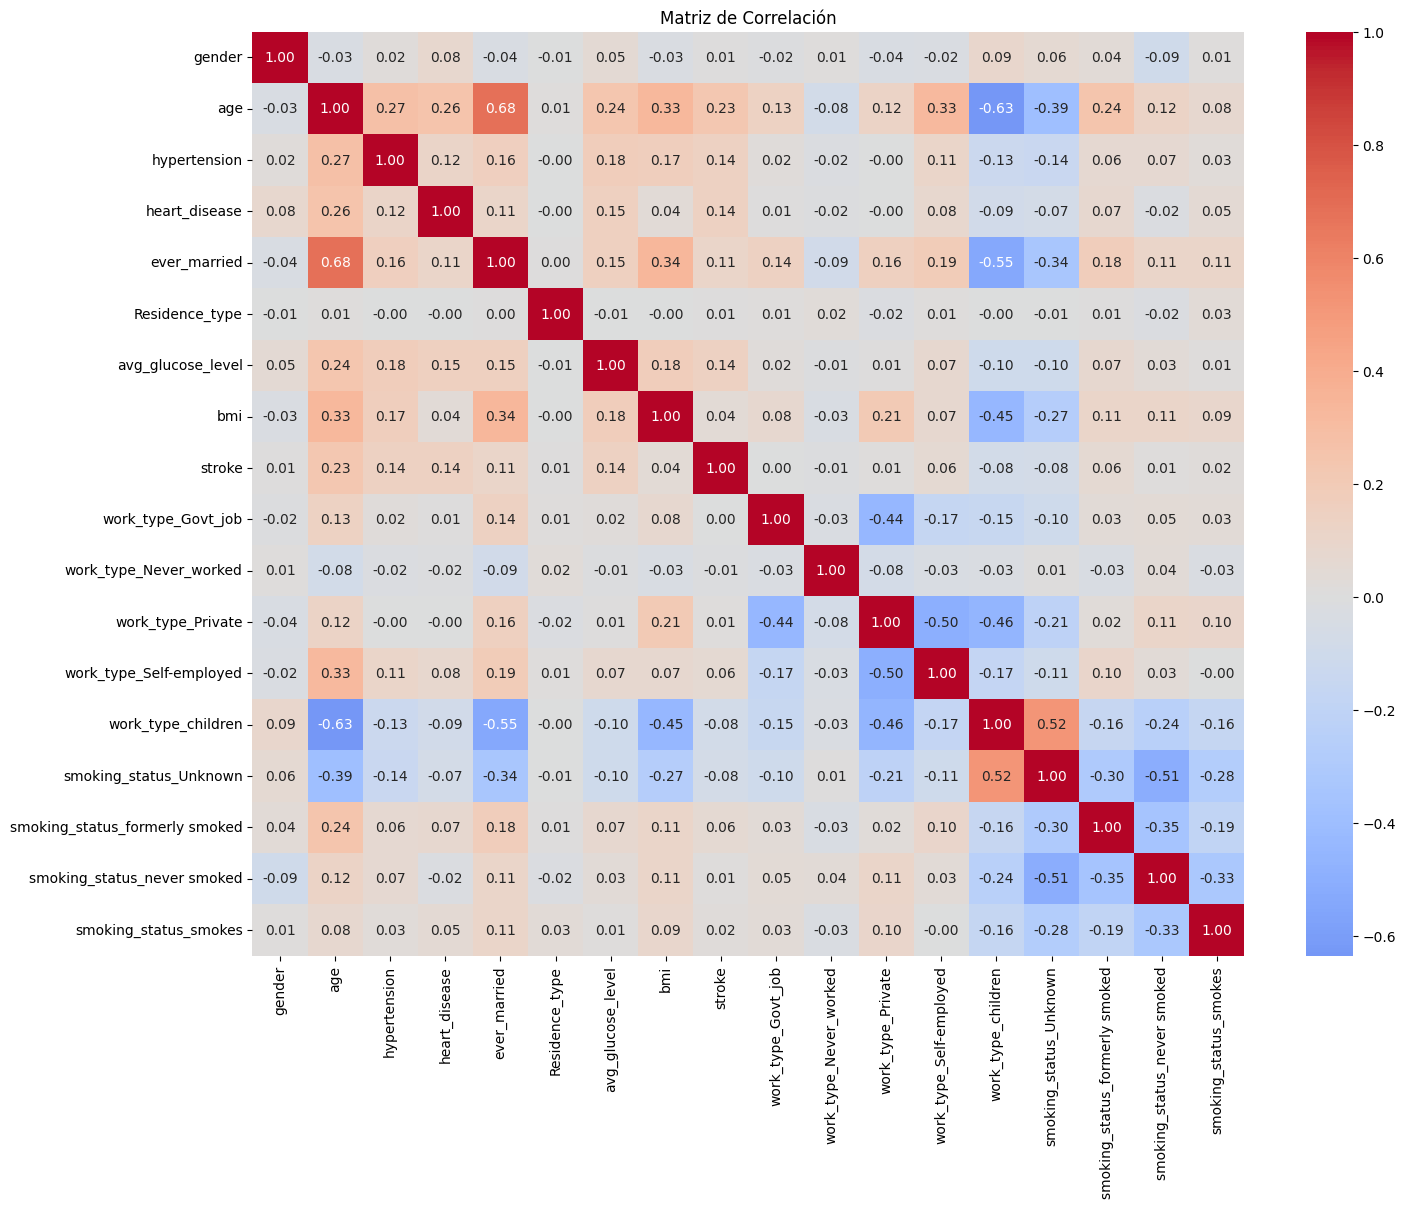


Matriz de Correlación Numérica:
                                  gender       age  hypertension  \
gender                          1.000000 -0.030738      0.021578   
age                            -0.030738  1.000000      0.274425   
hypertension                    0.021578  0.274425      1.000000   
heart_disease                   0.082712  0.257123      0.115991   
ever_married                   -0.037237  0.680782      0.162406   
Residence_type                 -0.005014  0.010948     -0.001074   
avg_glucose_level               0.053664  0.235838      0.180543   
bmi                            -0.026678  0.333398      0.167811   
stroke                          0.006757  0.232331      0.142515   
work_type_Govt_job             -0.015268  0.133593      0.019232   
work_type_Never_worked          0.012258 -0.079384     -0.021341   
work_type_Private              -0.038218  0.120021     -0.004637   
work_type_Self-employed        -0.022470  0.327347      0.111794   
work_type_child

In [6]:
#Creación de la matriz de correlación
#Creation of the correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(16, 12))  
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Matriz de Correlación")
plt.show()


print("\nMatriz de Correlación Numérica:")
print(correlation_matrix)


In [7]:
#Se asigan las variables independientes X
#Assign the independent variables
X = df[['age','hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']].values
#Se asignan la variable dependientes Y
#Assign the dependent variable Y
y = df["stroke"].values



In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)


In [10]:

# Calcular el ratio de clases desbalanceadas
num_pos = np.sum(y_train == 1)
num_neg = np.sum(y_train == 0)
scale_pos_weight = num_neg / num_pos

print(f"Clase 0 (negativa): {num_neg} muestras")
print(f"Clase 1 (positiva): {num_pos} muestras")
print(f"scale_pos_weight recomendado: {scale_pos_weight:.2f}")




Clase 0 (negativa): 3287 muestras
Clase 1 (positiva): 149 muestras
scale_pos_weight recomendado: 22.06


In [11]:
#Configure and training of the XGBOOST model
#Configuración y enternamiento del modelo XGBOOST
model = XGBClassifier(
    # Parámetros para desbalance
    scale_pos_weight=22,  # Tu ratio calculado
    
    # Parámetros para evitar overfitting
    max_depth=4,          # Reducido para evitar overfitting
    min_child_weight=6,   # Aumentado para casos minoritarios
    subsample=0.8,        # Submuestreo para generalización
    colsample_bytree=0.8, # Submuestreo de features
    
    # Parámetros de regularización
    reg_alpha=1,          # Regularización L1
    reg_lambda=1,         # Regularización L2
    
    # Otros parámetros
    n_estimators=200,     # Más árboles para mejor aprendizaje
    learning_rate=0.1,
    random_state=42,
    eval_metric='aucpr'   # Mejor métrica para datos desbalanceados
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=6, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [12]:
#Hacer predicciones con el modelo entrenado
#Make predictions eith the trained model
# Evaluación con Stratified CV (SMOTE se aplica SOLO en folds de train)
y_proba = model.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.4).astype(int)
print(y_proba)
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

[0.10258795 0.19345479 0.00220056 ... 0.00716567 0.05905531 0.02199311]
Matriz de confusión:
[[1197  216]
 [  25   35]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      1413
           1       0.14      0.58      0.23        60

    accuracy                           0.84      1473
   macro avg       0.56      0.72      0.57      1473
weighted avg       0.95      0.84      0.88      1473



In [13]:
from sklearn.metrics import precision_recall_curve
import numpy as np

prec, rec, thr = precision_recall_curve(y_test, y_proba)

# Calcular F1 con protección contra nan e inf
f1 = 2 * prec * rec / (prec + rec)
f1 = np.nan_to_num(f1, nan=0.0, posinf=0.0, neginf=0.0)  # reemplaza nan/inf por 0

best_idx = np.argmax(f1)

# Alinear índices (thr tiene len-1 respecto a prec/rec/f1)
best_thr = thr[best_idx-1] if best_idx == len(thr) else thr[best_idx]

print("Mejor threshold:", best_thr)
print("F1 en ese threshold:", f1[best_idx])

Mejor threshold: 0.41181076
F1 en ese threshold: 0.2302631578947368


C:\Users\baruj\AppData\Local\Temp\ipykernel_5984\1465029771.py:7: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


In [14]:
#Guardar el modelo entrenado
#Save the trained model
#joblib.dump(model, 'stroke_prediction_model.pkl')


In [15]:
ejemplos = [
    # Ejemplo 1: Persona mayor con factores de riesgo (probable stroke)
    [78, 1, 1, 240.5, 32.0],  # Edad avanzada + hipertensión + cardiopatía + glucosa alta
    
    # Ejemplo 2: Persona joven sin factores de riesgo (probable no stroke)
    [35, 0, 0, 85.0, 24.0],   # Joven + sin condiciones médicas + glucosa normal
    
    # Ejemplo 3: Caso límite (edad avanzada pero otros factores controlados)
    [68, 1, 0, 110.0, 28.5],  # Edad + hipertensión pero glucosa normal
    
    # Ejemplo 4: Niño (debería ser no stroke)
    [10, 0, 0, 75.0, 18.0],    # Niño sin factores de riesgo

    [67, 0, 1, 228.69, 36.0],

    [68,1,1,247.51,40.5],
    [75,0,0,78.8,29.3],


    [3,0,0,87.9,39.2],
    [58,1,0,87.9,39.2]
]

# Convertir a numpy array
#Convert to numpy array
X_ejemplos = np.array(ejemplos)


# Hacer predicciones
#make predictions
predicciones = model.predict(X_ejemplos)
probabilidades = model.predict_proba(X_ejemplos)

# Mostrar resultados detallados
#Show detailed results
print("Resultados de predicción:\n")
print("{:<10} {:<15} {:<20} {:<25}".format(
    "Ejemplo", "Predicción", "Probabilidad Stroke", "Características"))
print("-"*70)

for i, (pred, prob) in enumerate(zip(predicciones, probabilidades)):
    # Formatear las características para mostrar
    caracteristicas = f"Edad: {ejemplos[i][0]}, Hipertensión: {ejemplos[i][1]}, "
    caracteristicas += f"Cardiopatía: {ejemplos[i][2]}, Glucosa: {ejemplos[i][3]:.1f}, "
    caracteristicas += f"BMI: {ejemplos[i][4]:.1f}"
    
    print("{:<10} {:<15} {:<20.2%} {:<25}".format(
        f"Ejemplo {i+1}",
        "STROKE" if pred == 1 else "NO STROKE",
        prob[1],  # Probabilidad de clase positiva (stroke)
        caracteristicas
    ))



Resultados de predicción:

Ejemplo    Predicción      Probabilidad Stroke  Características          
----------------------------------------------------------------------
Ejemplo 1  STROKE          95.66%               Edad: 78, Hipertensión: 1, Cardiopatía: 1, Glucosa: 240.5, BMI: 32.0
Ejemplo 2  NO STROKE       2.18%                Edad: 35, Hipertensión: 0, Cardiopatía: 0, Glucosa: 85.0, BMI: 24.0
Ejemplo 3  STROKE          74.61%               Edad: 68, Hipertensión: 1, Cardiopatía: 0, Glucosa: 110.0, BMI: 28.5
Ejemplo 4  NO STROKE       0.16%                Edad: 10, Hipertensión: 0, Cardiopatía: 0, Glucosa: 75.0, BMI: 18.0
Ejemplo 5  STROKE          51.21%               Edad: 67, Hipertensión: 0, Cardiopatía: 1, Glucosa: 228.7, BMI: 36.0
Ejemplo 6  STROKE          96.77%               Edad: 68, Hipertensión: 1, Cardiopatía: 1, Glucosa: 247.5, BMI: 40.5
Ejemplo 7  NO STROKE       47.87%               Edad: 75, Hipertensión: 0, Cardiopatía: 0, Glucosa: 78.8, BMI: 29.3
Ejemplo 8  N

In [16]:

def predecir_stroke(age, hypertension, heart_disease, avg_glucose_level, bmi, 
                   modelo, umbral=0.5):

    try:
        # 1. Validar inputs
        if not all(isinstance(val, (int, float)) for val in [age, avg_glucose_level, bmi]):
            raise ValueError("Los valores numéricos deben ser int o float")
        
        if hypertension not in [0, 1] or heart_disease not in [0, 1]:
            raise ValueError("hypertension y heart_disease deben ser 0 o 1")
        
        # 2. Preparar datos
        datos_paciente = np.array([[age, hypertension, heart_disease, 
                                 avg_glucose_level, bmi]])
        
   
        
        # 4. Predecir probabilidad
        proba = modelo.predict_proba(datos_paciente)[0]
        
        # 5. Clasificar según umbral
        prediccion = 1 if proba[1] >= umbral else 0
        
        # 6. Interpretación para humanos
        interpretacion = (
            "Alto riesgo de stroke" if prediccion == 1 
            else "Bajo riesgo de stroke"
        )
        
        # 7. Retornar resultados estructurados
        return {
            'prediccion': int(prediccion),
            'probabilidad_stroke': float(proba[1]),
            'probabilidad_no_stroke': float(proba[0]),
            'interpretacion': interpretacion,
            'status': 'success'
        }
        
    except Exception as e:
        return {
            'status': 'error',
            'message': f"Error en la predicción: {str(e)}"
        }

In [17]:
resultado = predecir_stroke(
    age=67,
    hypertension=0,
    heart_disease=1,
    avg_glucose_level=229.5,
    bmi=36.3,
    modelo=model
)
#  [67, 0, 1, 228.69, 36.0] 
print(resultado)

{'prediccion': 1, 'probabilidad_stroke': 0.5783842206001282, 'probabilidad_no_stroke': 0.4216157793998718, 'interpretacion': 'Alto riesgo de stroke', 'status': 'success'}


In [18]:
#Function to use
def predict_stroke(age, hypertension, heart_disease, avg_glucose_level, bmi):
    """
    Recibe los parámetros del formulario y devuelve una predicción
    """
    # Crear array con los datos de entrada
    #Create array with the input data
    input_data = np.array([[age, hypertension, heart_disease, avg_glucose_level, bmi]])
    
    # Hacer la predicción
    #Make the prediction
    prediction = model.predict(input_data)
    probability = model.predict_proba(input_data)
    
    return {
        "prediction": int(prediction[0]),
        "probability": float(probability[0][1]),  # Probabilidad de stroke
        "risk_level": "Alto" if probability[0][1] > 0.7 else "Moderado" if probability[0][1] > 0.3 else "Bajo"
    }

In [19]:
result = predict_stroke(
    age=75,
    hypertension=1,
    heart_disease=0,
    avg_glucose_level=180.5,
    bmi=35.3
)
#  [67, 0, 1, 228.69, 36.0] 
print(result)

{'prediction': 1, 'probability': 0.6816853284835815, 'risk_level': 'Moderado'}
